# Overview
This Jupyter notebook describes the case study for the the autonomous systems case study.

In [1]:
# Import libraries
from case_study import *
from PIL import Image

from pacti.terms.polyhedra import PolyhedralContract

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`
`omega.symbolic.symbolic` failed to import `dd.cudd`.
Will use `dd.autoref`.
`tulip` failed to import `cvxopt`.
No quadratic cost for controller computation.


## Part 1: Example

In [2]:
TILESIZE = 50
ORIENTATIONS = {"n": 270, "e": 0, "s": 90, "w": 180, "ne": 315, "nw": 225, "se": 45, "sw": 135}
START_CROSSWALK = -1
END_CROSSWALK = 2
CROSSWALK_V = 1
CROSSWALK_LOCATIONS = dict()
ped_loc = []
for i, num in enumerate(range(2 * START_CROSSWALK, 2 * (END_CROSSWALK + 1))):
    CROSSWALK_LOCATIONS.update({i: (num / 2, CROSSWALK_V)})
    ped_loc.append(num / 2)

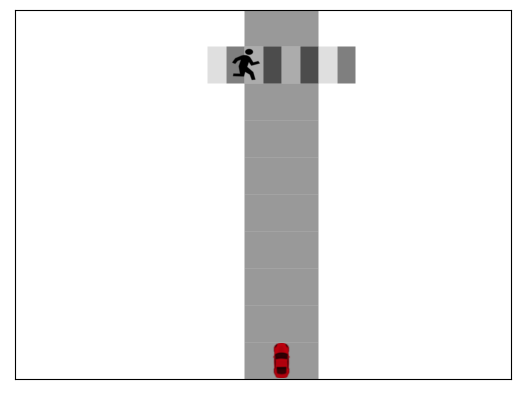

<Figure size 640x480 with 0 Axes>

In [3]:
class GridCar:
    def __init__(self):
        self.xc_init = 0
        self.vc_init = 0
        self.ped = 1
        self.N = 10
        self.Vmax = 2
        self.xped = 10 - CROSSWALK_V
        self.main_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
        self.car_fig = self.main_dir + "/evaluating_perception/imglib/red_car.png"
        self.ped_fig = self.main_dir + "/evaluating_perception/imglib/pedestrian_img.png"
        self.car_data = [9, 0]
        if self.ped == 1:
            self.ped_data = [CROSSWALK_V, min(ped_loc)]
        else:
            self.ped_data = None

    def dynamics(self):
        transitions = dict()
        for x in range(0, self.N):
            x_succ = []
            for v in range(0, self.Vmax):
                x_succ.append(x + v)
            transitions[x] = x_succ
        return transitions

    def plot_grid(self):
        size = [1, self.N]
        x_min = 0
        x_max = size[0] * TILESIZE
        y_min = 0
        y_max = size[1] * TILESIZE
        # x_min, x_max, y_min, y_max = get_map_corners(map)

        fig, ax = plt.subplots()
        ax.axis("equal")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        # fill in the road regions
        road_tiles = []
        width_tiles = np.arange(0, size[0] + 1) * 2 * TILESIZE
        lanes_tiles = np.arange(0, size[1] + 1) * TILESIZE

        for i in np.arange(0, size[0]):
            for k in np.arange(0, size[1] + 1):
                tile = patches.Rectangle(
                    (width_tiles[i], lanes_tiles[k]), 2 * TILESIZE, TILESIZE, linewidth=1, facecolor="k", alpha=0.4
                )
                road_tiles.append(tile)
        ax.add_collection(PatchCollection(road_tiles, match_original=True))

        # now add crosswalk on top
        crosswalk_tiles = []
        for item in CROSSWALK_LOCATIONS.keys():
            if item % 2 == 0:
                color = "silver"
                alpha = 0.5
            else:
                color = "k"
                alpha = 0.5
            width = CROSSWALK_LOCATIONS[item][0] * TILESIZE
            lanes = CROSSWALK_LOCATIONS[item][1] * TILESIZE
            tile = patches.Rectangle((width, lanes), TILESIZE / 2, TILESIZE, linewidth=1, facecolor=color, alpha=alpha)
            crosswalk_tiles.append(tile)
        ax.add_collection(PatchCollection(crosswalk_tiles, match_original=True))
        # TODO: Add cross-walk tile names next to the cells
        plt.gca().invert_yaxis()
        return ax

    def plot_car(self, ax):
        y_tile, speed = self.car_data
        theta_d = 270  # Rotate car to face north
        x = (1) * TILESIZE / 2
        y = (y_tile) * TILESIZE
        car_fig = Image.open(self.car_fig)
        car_fig = car_fig.rotate(theta_d, expand=False)
        offset = 0.1
        ax.imshow(
            car_fig, zorder=1, interpolation="bilinear", extent=[x + 2, x + TILESIZE - 2, y + 2, y + TILESIZE - 2]
        )
        return ax

    def plot_ped(self, ax):
        y_tile, x_tile = self.ped_data
        x = (x_tile) * TILESIZE / 2
        y = (y_tile) * TILESIZE
        ped_fig = Image.open(self.ped_fig)
        ped_fig = ped_fig.rotate(180, expand=False)
        offset = 0.1
        ax.imshow(
            ped_fig, zorder=1, interpolation="bilinear", extent=[x + 4, x + TILESIZE - 2, y + 2, y + TILESIZE - 2]
        )
        return ax

    # Function to calculate all system states:
    def construct_transitions(self):
        T = dict()
        for xcar in range(1, self.N + 1):
            for vcar in range(0, self.Vmax + 1):
                st = (xcar, vcar)
                end_st = []
                if xcar == self.N:
                    end_st.append((xcar, vcar))
                elif vcar == 0:
                    xcar_p = min(self.N, xcar + 1)
                    end_st.append((xcar, vcar))
                    end_st.append((xcar_p, vcar + 1))
                    end_st.append((xcar, vcar + 1))
                else:
                    xcar_p = min(self.N, xcar + vcar)
                    end_st.append((xcar_p, vcar))
                    end_st.append((xcar_p, vcar - 1))
                    if vcar < Vhigh:
                        end_st.append((xcar_p, vcar + 1))
                T[st] = end_st
        return T

    # System states for pedestrian
    def system_states_example_ped(self):
        nS = self.N * (self.Vmax + 1)
        state = lambda x, v: (self.Vmax + 1) * (x - 1) + v
        state_to_S = dict()
        S = set()
        for xcar in range(1, self.N + 1):
            for vcar in range(0, self.Vmax + 1):
                st = "S" + str(state(xcar, vcar))
                state_to_S[xcar, vcar] = st
                S |= {st}
        T = self.construct_transitions()
        return S, state_to_S, T


# Generate grid and figure:
grid = GridCar()
ax = grid.plot_grid()
ax = grid.plot_car(ax)
ax = grid.plot_ped(ax)

plt.show()
plt.savefig(grid.main_dir + "/evaluating_perception/imglib/car_ped_ex.png")

## Part 2: Getting probability points for ped, obj, empty:

In [5]:
# Here we load probability points from saved pickle files. To recompute the probabilities, then set recompute to True
vmax = 2
Ncar = 6
Vlow = 0
Vhigh = vmax
recompute = False

# Computing pedestrian prob points:
true_env = "ped"
if recompute:
    xped, bad_states_ped, good_state_ped, formula = new_initialize_ped(vmax, Ncar, true_env)
    points_ped, tpped_vals = gen_points(Ncar, Vlow, Vhigh, xped, bad_states_ped, good_state_ped, formula, vmax)
    # Save results and plot:
    plot_probabilities(points_ped, tpped_vals, true_env, vmax)
    fn = save_result(points_ped, tpped_vals, true_env, vmax, Ncar)

# Derive bounds and plot probability bounds:
else:
    fn = "data/points_" + true_env + "_lb0.6_ub0.999_vmax2_N6rand.pkl"

ubounds_ped, lbounds_ped, points_ped, tpped_vals = derive_prob_bounds(fn, true_env)
# plot_probabilities_bounds(points_ped, tpped_vals, true_env, vmax, Ncar, ubounds_ped, lbounds_ped, rand =True)

# Computing object prob points:
true_env = "obj"
if recompute:
    xped, bad_states_ped, good_state_ped, formula = new_initialize_ped(vmax, Ncar, true_env)
    points_obj, tpobj_vals = gen_points_obj(Ncar, Vlow, Vhigh, xped, bad_states_ped, good_state_ped, formula, vmax)
    # Save results and plot:
    plot_probabilities(points_obj, tpobj_vals, true_env, vmax)
    fn = save_result(points_obj, tpobj_vals, true_env, vmax, Ncar)

# Derive bounds and plot probability bounds:
else:
    fn = "data/points_" + true_env + "_lb0.6_ub0.999_vmax2_N6rand.pkl"

ubounds_obj, lbounds_obj, points_obj, tpobj_vals = derive_prob_bounds(fn, true_env)
# plot_probabilities_bounds(points_obj, tpobj_vals, true_env, vmax, Ncar, ubounds_obj, lbounds_obj, rand =True)

# Computing prob points for empty:
true_env = "empty"
if recompute:
    xped, bad_states_ped, good_state_ped, formula = new_initialize_ped(vmax, Ncar, true_env)
    points_rmp, tpemp_vals = gen_points_emp(Ncar, Vlow, Vhigh, xped, bad_states_ped, good_state_ped, formula, vmax)
    # Save results and plot:
    plot_probabilities(points_emp, tpemp_vals, true_env, vmax)
    fn = save_result(points_emp, tpemp_vals, true_env, vmax, Ncar)

# Derive bounds and plot probability bounds:
else:
    fn = "data/points_" + true_env + "_lb0.6_ub0.999_vmax2_N6rand.pkl"

ubounds_emp, lbounds_emp, points_emp, tpemp_vals = derive_prob_bounds(fn, true_env)
# plot_probabilities_bounds(points_emp, tpemp_vals, true_env, vmax, Ncar, ubounds_emp, lbounds_emp, rand =True)

## Part 3: Controller Contracts

In [7]:
# First we construct each contract individually, and then merge the controller contract:
## Control contract for pedestrian class
def control_contract_ped(lbounds_ped):
    lb_m, lb_c = lbounds_ped
    mc = dict()
    mc = {
        "input_vars": ["tp_ped"],
        "output_vars": ["P_ped"],
        "assumptions": [
            {"coefficients": {"tp_ped": 1}, "constant": 1},
            {"coefficients": {"tp_ped": -1}, "constant": -0.6},
        ],
        "guarantees": [{"coefficients": {"P_ped": -1, "tp_ped": lb_m}, "constant": -1 * lb_c}],
    }
    return mc


def control_contract_obj(lbounds_obj):
    lb_m, lb_c = lbounds_obj
    mc = dict()
    mc = {
        "input_vars": ["tp_obj"],
        "output_vars": ["P_obj"],
        "assumptions": [
            {"coefficients": {"tp_obj": 1}, "constant": 1},
            {"coefficients": {"tp_obj": -1}, "constant": -0.3},
        ],
        "guarantees": [{"coefficients": {"P_obj": -1, "tp_obj": lb_m}, "constant": -1 * lb_c}],
    }
    return mc


def control_contract_emp(lbounds_emp):
    lb_m, lb_c = lbounds_emp
    mc = dict()
    mc = {
        "input_vars": ["tp_emp"],
        "output_vars": ["P_emp"],
        "assumptions": [
            {"coefficients": {"tp_emp": 1}, "constant": 1},
            {"coefficients": {"tp_emp": -1}, "constant": -0.6},
        ],
        "guarantees": [{"coefficients": {"P_emp": -1, "tp_emp": lb_m}, "constant": -1 * lb_c}],
    }
    return mc


Cped = PolyhedralContract.from_dict(control_contract_ped(lbounds_ped))
Cobj = PolyhedralContract.from_dict(control_contract_obj(lbounds_obj))
Cemp = PolyhedralContract.from_dict(control_contract_emp(lbounds_emp))

print("Controller Contract for pedestrian class:\n" + str(Cped) + "\n")
print("Controller Contract for object class:\n" + str(Cobj) + "\n")
print("Controller Contract for empty class:\n" + str(Cemp) + "\n")

Controller Contract for pedestrian class:
InVars: [<Var tp_ped>]
OutVars:[<Var P_ped>]
A: 1*tp_ped <= 1.0, -1*tp_ped <= -0.6
G: -1.0*P_ped + 1.7897800905324535*tp_ped <= 0.789889410441921

Controller Contract for object class:
InVars: [<Var tp_obj>]
OutVars:[<Var P_obj>]
A: 1*tp_obj <= 1.0, -1*tp_obj <= -0.3
G: -1.0*P_obj + 0.06419368421050975*tp_obj <= -0.9322840694736975

Controller Contract for empty class:
InVars: [<Var tp_emp>]
OutVars:[<Var P_emp>]
A: 1*tp_emp <= 1.0, -1*tp_emp <= -0.6
G: -1.0*P_emp + 0.20049999999999998*tp_emp <= -0.7997000000000001



## Part 4: Computing desired probabilities for Confusion Matrix

In [8]:
# Construct merger of contracts:
C_controller = Cped.compose(Cobj)
C_controller = C_controller.compose(Cemp)

print("Merged Controller Contract for all object classes:\n" + str(C_controller) + "\n")

Merged Controller Contract for all object classes:
InVars: [<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: 1*tp_ped <= 1.0, -1*tp_ped <= -0.6, 1*tp_obj <= 1.0, -1*tp_obj <= -0.30000000000000004, 1*tp_emp <= 1.0, -1*tp_emp <= -0.6
G: -1.0*P_ped + 1.7897800905324535*tp_ped <= 0.789889410441921, -1.0*P_obj + 0.06419368421050975*tp_obj <= -0.9322840694736975, -1.0*P_emp + 0.20049999999999998*tp_emp <= -0.7997000000000001



## Part 4a: Numerical Bounds

In [15]:
## System contract: P >= 0.99 for each class
def system_contract():
    system_contract = {
        "input_vars": ["x_e"],
        "output_vars": ["P_ped", "P_obj", "P_emp"],
        "assumptions": [{"coefficients": {"x_e": -1}, "constant": -1}, {"coefficients": {"x_e": 1}, "constant": 1}],
        "guarantees": [
            {"coefficients": {"P_ped": -1}, "constant": -0.99},
            #             {"coefficients":{"P_ped":1},
            #             "constant":1},
            {"coefficients": {"P_obj": -1}, "constant": -0.80},
            #             {"coefficients":{"P_obj":1},
            #             "constant":1},
            {"coefficients": {"P_emp": -1}, "constant": -0.95},
            #             {"coefficients":{"P_emp":1},
            #             "constant":1}
        ],
    }
    return system_contract


Csys = PolyhedralContract.from_dict(system_contract())
print("System Contract (numerical bounds):\n" + str(Csys) + "\n")

System Contract (numerical bounds):
InVars: [<Var x_e>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*x_e <= -1.0, 1*x_e <= 1.0
G: -1*P_ped <= -0.99, -1*P_obj <= -0.8, -1*P_emp <= -0.95



In [16]:
# Computing quotient contract:
C_numerical = Csys.quotient(C_controller)
print("Quotient Contract with numerical bounds on true positive rates:\n" + str(C_numerical) + "\n")

Quotient Contract with numerical bounds on true positive rates:
InVars: [<Var x_e>]
OutVars:[<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
A: -1*x_e <= -1.0, 1*x_e <= 1.0
G: -1.78978009053245*tp_ped <= -1.77988941044192, -0.200500000000000*tp_emp <= -0.150300000000000, 1*tp_ped <= 1.0, 1*tp_obj <= 1.0, -1*tp_obj <= -0.30000000000000004, 1*tp_emp <= 1.0



In [18]:
-0.150300000000000 / -0.200500000000000

0.7496259351620946

## Part 4b: Bounds depending on distance

In [20]:
## System contract: P >= 0.99
def system_contract_dist():
    system_contract = {
        "input_vars": ["d"],
        "output_vars": ["P_ped", "P_obj", "P_emp"],
        "assumptions": [{"coefficients": {"d": -1}, "constant": 0}, {"coefficients": {"d": 1}, "constant": 10}],
        "guarantees": [
            {"coefficients": {"P_ped": -1, "d": -0.099}, "constant": -0.99},
            #             {"coefficients":{"P_ped":1, "d":0.00},
            #             "constant":1},
            {"coefficients": {"P_obj": -1, "d": -0.08}, "constant": -0.8},
            #             {"coefficients":{"P_obj":1, "d":0},
            #             "constant":1},
            {"coefficients": {"P_emp": -1, "d": -0.095}, "constant": -0.95},
            #             {"coefficients":{"P_emp":1, "d":0.0},
            #             "constant":1}
        ],
    }
    return system_contract


Csys_dist = PolyhedralContract.from_dict(system_contract_dist())
print("System Contract (distance bounds):\n" + str(Csys_dist) + "\n")

System Contract (distance bounds):
InVars: [<Var d>]
OutVars:[<Var P_ped>, <Var P_obj>, <Var P_emp>]
A: -1*d <= 0.0, 1*d <= 10.0
G: -1.0*P_ped + -0.099*d <= -0.99, -1.0*P_obj + -0.08*d <= -0.8, -1.0*P_emp + -0.095*d <= -0.95



In [23]:
# Computing quotient contract:
C_dist = Csys_dist.quotient(C_controller)
print("Quotient Contract with distance bounds on true positive rates:\n" + str(C_dist) + "\n")

Quotient Contract with distance bounds on true positive rates:
InVars: [<Var d>]
OutVars:[<Var tp_ped>, <Var tp_obj>, <Var tp_emp>]
A: -1*d <= 0.0, 1*d <= 10.0
G: -0.099*d + -1.78978009053245*tp_ped <= -1.77988941044192, -0.095*d + -0.200500000000000*tp_emp <= -0.150300000000000, 1*tp_ped <= 1.0, -1*tp_ped <= -0.6, 1*tp_obj <= 1.0, -1*tp_obj <= -0.30000000000000004, 1*tp_emp <= 1.0, -1*tp_emp <= -0.6



In [26]:
0.15030000000 / 0.200500000000000

0.7496259351620946